In [84]:
import pandas as pd
import numpy as np


N = 50000

u = np.random.normal(1, size=N)
z = np.maximum(0, u + np.random.uniform(0, 5, size=N))

delta = u
z_0 = 5.
p_x =  (z < z_0) * 0 + (z >= z_0) * 1
x = p_x

epsilon = 0.1*np.random.normal(size=N)
y = delta*x + z + epsilon
y0 = z + epsilon
y1 = delta + z + epsilon

df = pd.DataFrame({'X': x, 'Z': z, 'Y': y, # observable
                   'Y1': y1, 'Y0': y0, 'U': u}) # unobservable

## Is the data biased? The true ATE averages 1, since the individual effect is just U.

In [85]:
df.groupby('X').mean()['Y'][1] - df.groupby('X').mean()['Y'][0]

4.8317535964108

so we have bias around 3.8

# Let's examine our assumptions.

1. There is a discontinuity, $$lim_{z \rightarrow z_0^+ } P(X|Z=z) \neq lim_{z \rightarrow z_0^- } P(X|Z=z)$$
2. The counterfactuals are continuous at the discontinuity
3. $\delta \perp X | Z = z_0$

## 1. How does P(X|Z) look at the discontinuity?

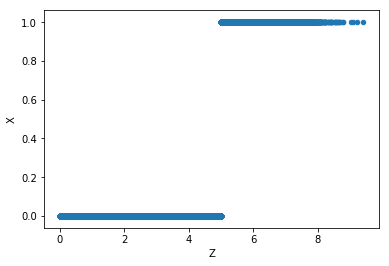

In [86]:
df.plot(x='Z', y='X', kind='scatter')

So we see there's a jump discontinuity, and can confirm assumption 1.

## 2. The counterfactuals are continuous at $Z=Z_0$ 

We can't confirm this directly, since we can't measure the counterfactuals for everyone! Instead, since we hope that people near the discontinuity are similar, we can at least inspect the selection variable.

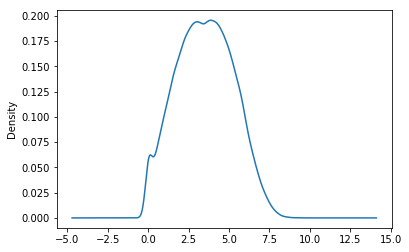

In [87]:
df.Z.plot.kde()

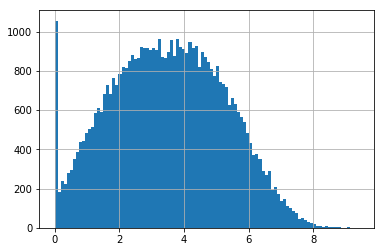

In [88]:
df.Z.hist(bins=100)

If there were pileup before or after the threshold, we'd have to worry about self-selection at the discontinuity, so variation in the causal state due to the discontinuity could be confounded (this is related to the next condition as well). 

There's no pileup above or below $z_0 = 5$, so we've done what we can to search for self-selection.

## 3. $\delta \perp X | Z = z_0$

We have deterministic assignment with $Z$, so $Z$ forms a back-door set for the effect of $X$ on $Y$. We can verify by looking at the same plot above, and seeing everyone above the threshold $Z=5$ has $X=1$, and below has $X=0$.

# Estimation

Having  checked our assumptions, let's build models for E[Y|Z] on either side of the discontinuity.

In [81]:
from sklearn.neighbors import RadiusNeighborsRegressor


model_left = RadiusNeighborsRegressor(radius=0.05)
model_left = model_left.fit(df[df.Z < z_0][['Z']], df[df.Z < z_0]['Y'])

model_right = RadiusNeighborsRegressor(radius=0.05)
model_right = model_right.fit(df[df.Z >= z_0][['Z']], df[df.Z >= z_0]['Y'])

def predict_y(z):
    if z < z_0:
        return model_left.predict([[z]])[0]
    else:
        return model_right.predict([[z]])[0]

df['E[Y|Z]'] = df['Z'].apply(predict_y)

### Our estimate is the gap

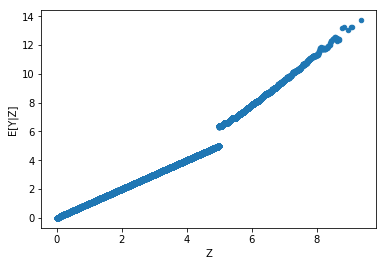

In [82]:
df.plot(x='Z', y='E[Y|Z]', kind='scatter')

In [83]:
model_right.predict([[z_0]]) - model_left.predict([[z_0]])

array([1.36845488])

### Did we have continuity in the potential outcomes?

In [89]:
from sklearn.neighbors import RadiusNeighborsRegressor


model_left = RadiusNeighborsRegressor(radius=0.1)
model_left = model_left.fit(df[df.Z < z_0][['Z']], df[df.Z < z_0]['Y0'])

model_right = RadiusNeighborsRegressor(radius=0.1)
model_right = model_right.fit(df[df.Z >= z_0][['Z']], df[df.Z >= z_0]['Y0'])

def predict_y(z):
    if z < z_0:
        return model_left.predict([[z]])[0]
    else:
        return model_right.predict([[z]])[0]

df['y_pred'] = df['Z'].apply(predict_y)

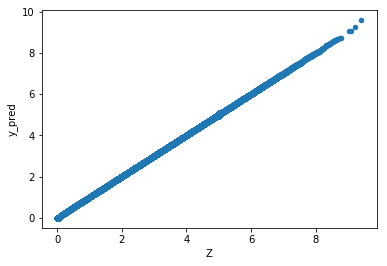

In [90]:
df.plot(x='Z', y='y_pred', kind='scatter')

In [91]:
model_right.predict([[z_0]]) - model_left.predict([[z_0]])

array([0.10049658])

### Did we get the right estimate of the treatment effect? 

$\delta = U$, so we can look at $E[U|Z]$ in this case to confirm (not possible in practice)

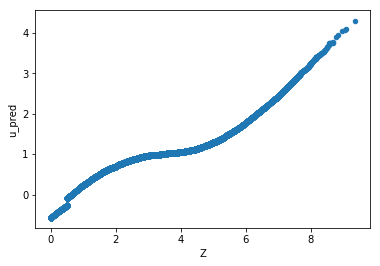

In [69]:
model = RadiusNeighborsRegressor(radius=0.5)
model = model.fit(df[['Z']], df['U'])
df['u_pred'] = model.predict(df[['Z']])
df.plot(x='Z', y='u_pred', kind='scatter')

In [92]:
model.predict([[z_0]])

array([1.28657119])

In [14]:
from statsmodels.api import OLS


ep = 0.05
df['intercept'] = 1.
df_z0 = df[df.Z < z_0 + ep][df.Z > z_0 - ep]


model = OLS(endog=df_z0['Y'], exog=df_z0[['X', 'intercept']])
result = model.fit()
result.summary()

/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     1141.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          6.70e-158
Time:                        21:18:55   Log-Likelihood:                -744.18
No. Observations:                 830   AIC:                             1492.
Df Residuals:                     828   BIC:                             1502.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.3954      0.041     33.776      0.000       1.314       1.476
intercept      4.9763      0.028    176.173      0.000       4.921       5.032
==============================================================================
Omnibus:                      199.954   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              789.791
Skew:                           1.081   Prob(JB):                    3.16e-172
Kurtosis:                       7.262   Cond. No.                         2.55
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""